In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import copy

root = '/usr/local/serenceslab/maggie/shapeDim/'

sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils
from code_utils import stats_utils, plot_utils


In [2]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 7
subjects = np.arange(1,8)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [3]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
   

In [4]:
from code_utils import grid_utils
grid_pts = grid_utils.get_main_grid()
# NOTE i am swapping the columns here
# because this is the order you get from doing np.unique(pts)
# this is the actual order that the predictions 1-16 of this classifier
# correspond to. 
grid_pts = grid_pts[:,[1,0]] 

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_multiclass_withintask.npy')
dec_withintask = np.load(save_filename, allow_pickle=True).item()
dec_withintask.keys()
roi_names = dec_withintask['roi_names']
roi_names[-1] = 'IPS'
n_rois = len(roi_names)

#### Compute binary classification accuracy for different sets of trials
Far = furthest rows from boundary

Middle = closer rows to boundary, but still in main grid


In [6]:
n_tasks = 4

conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
dprime_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

for si, ss in enumerate(subjects):

    # loop over tasks
    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        
        is_main_grid = l['is_main_grid']==1
        
        # use correct trials only here
        correct = np.array(l['subject_correct'])
        
        # loop over "axes" - which boundary to compute accuracy for
        for ii in [0,1]:

            categ_actual = l['categ_task%d'%(ii+1)]
            coord_actual = pt_labs[:,ii].round(2)
           
            # far is the furthest from bound
            # middle is second furthest
            dist_from_center = l['dist_from_bound%d'%(ii+1)].round(2)
            is_near = dist_from_center<0.8
            is_far = (dist_from_center==2.4) & is_main_grid
            is_middle = (dist_from_center==0.8) & is_main_grid
           
            # loop over ROIs
            for ri in range(n_rois):

                pred = dec_withintask['preds_all'][si][ri][ti].astype(int)
                
                # binarize the predictions of 16-way classifier into 2 categories
                # based on current axis "ii"
                coords_pred = grid_pts[pred]
                categ_pred = grid_utils.get_categ(coords_pred, ii+1)
                
                prob = dec_withintask['probs_all'][si][ri][ti]
                
                # "confidence" in assignment to category 2 vs 1
                # group the 16 points into categories w/r/t relevant axis
                g1 = grid_utils.get_categ(grid_pts, ii+1)==1
                p_categ1 = np.sum(prob[:,g1], axis=1)
                g2 = grid_utils.get_categ(grid_pts, ii+1)==2
                p_categ2 = np.sum(prob[:,g2], axis=1)
                
                # signed confidence will be: p(correct) - p(incorrect)
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]
                
                
                inds = is_main_grid & correct
                
                conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_allmaintrials[si,ri,ti,ii] = d;
                
                acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # far trials
                inds = is_far & correct
                                                          
                conf_fartrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_fartrials[si,ri,ti,ii] = d;
                
                acc_fartrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # middle trials
                inds = is_middle & correct
                                                      
                conf_midtrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                d = stats_utils.get_dprime(categ_pred[inds], categ_actual[inds])
                dprime_midtrials[si,ri,ti,ii] = d;
                
                acc_midtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                

#### Get confidence for nearest trials

For the nearest trials, the average confidence values are generated by resampling 
the center grid trials so that the distribution of stims is more even across tasks.

this is done in bootstrap_confidence.py (i saved it to disk because it takes ~10 minutes to run)

can skip to next cell if it's done already

In [16]:
from multinomial_decoding import bootstrap_confidence
# bootstrap_confidence.bootstrap_binary_hardtrials(n_boot_iter=1000)

In [7]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
fn2load = os.path.join(save_folder, 'decode_multiclass_binary_hardtrials_bootstrap_correctonly.npy')
print(fn2load)
b = np.load(fn2load, allow_pickle=True).item()
b.keys()
signedconf_neartrials_boot = b['signedconf_hardtrials_boot']
conf_neartrials = np.mean(signedconf_neartrials_boot, axis=4)

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_multiclass_binary_hardtrials_bootstrap_correctonly.npy


In [8]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

[-0.04542350400620719, 0.7495612081475718]
[-0.03898403468950567, 0.48325403153694135]
[-0.3834570205272797, 0.4728628525302239]


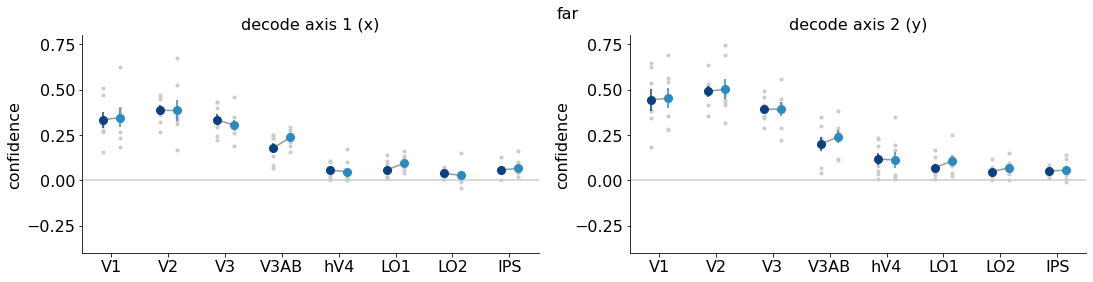

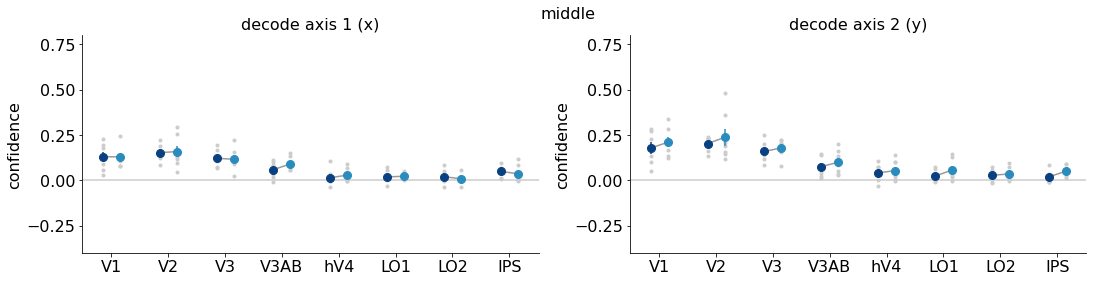

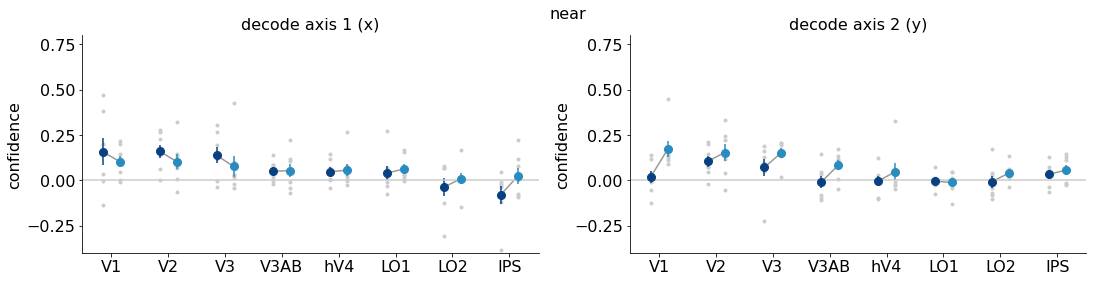

In [9]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15,2)

for rvals, name in zip([conf_fartrials, conf_midtrials, conf_neartrials], \
                     ['far','middle','near']):    
    
    print([np.min(rvals.ravel()),np.max(rvals.ravel())])
    plt.figure(figsize=(18,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        ax = plt.subplot(1,2,ii+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = rvals[:,:,ti,ii]
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, \
                     markersize=8, \
                     # markerfacecolor='none', \
                    )
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6],zorder=-5)

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
            
        plt.ylim([-0.40, 0.8])
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        # plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)

    plt.suptitle('%s'%name)
    
    figname = os.path.join(figfolder, 'multi_binary_%s.pdf'%(name))
    plt.savefig(figname)


#### three-way RM anova
save result to disk bc shuffled test is very slow

In [11]:
for xx, [cvals, diffname] in enumerate(zip([conf_fartrials, conf_midtrials, conf_neartrials], \
                        ['far','middle','near'])):

    
    vals = copy.deepcopy(cvals[:,:,0:2,0:2])

    anova_result = stats_utils.rmanova_3way(vals, ['ROI','Task','Boundary'], \
                                            # do_shuffle=False)
                                           do_shuffle=True, n_iter=10000, rndseed = 675677+xx)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    tablename = os.path.join(figfolder, 'binary_conf_lin1vs2_rm_anova_%s.csv'%(diffname))
    
    print(tablename)
    anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_conf_lin1vs2_rm_anova_far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_conf_lin1vs2_rm_anova_middle.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_conf_lin1vs2_rm_anova_near.csv


#### print test results

In [10]:
for diffname in ['far','middle','near']:
    
    tablename = os.path.join(figfolder, 'binary_conf_lin1vs2_rm_anova_%s.csv'%(diffname))
    anova_result = pd.read_csv(tablename, index_col=0)
    print('\nAnova for confidence, %s trials'%(diffname))
    
    print(anova_result)


Anova for confidence, far trials
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI                43.490356     7.0    42.0  0.0000           0.0000
Task                0.651793     1.0     6.0  0.4503           0.4532
Boundary           22.091703     1.0     6.0  0.0033           0.0025
ROI:Task            0.444169     7.0    42.0  0.8685           0.8710
ROI:Boundary       12.066132     7.0    42.0  0.0000           0.0000
Task:Boundary       0.646886     1.0     6.0  0.4519           0.4559
ROI:Task:Boundary   0.712959     7.0    42.0  0.6613           0.6624

Anova for confidence, middle trials
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI                24.368585     7.0    42.0  0.0000           0.0000
Task                3.098721     1.0     6.0  0.1288           0.1243
Boundary           21.205794     1.0     6.0  0.0037           0.0036
ROI:Task            0.211044     7.0    42.0  0.9810           0.9826
ROI:Boundary       

#### two-way RM anova, within each distance bin

In [13]:
for cvals, diffname in zip([conf_fartrials, conf_midtrials, conf_neartrials], \
                        ['far','middle','near']):

    for ii, axis_name in enumerate(['axis1','axis2']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])

        anova_result = stats_utils.rmanova_2way(vals, ['ROI','Task'], \
                                                do_shuffle=True, n_iter=10000, rndseed = 243434+ii)

        
        anova_result['Pr > F'] = anova_result['Pr > F'].round(4)
    
        tablename = os.path.join(figfolder, 'binary_conf_rm_anova_%s_%s.csv'%(axis_name, diffname))
    
        print(tablename)
        anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_conf_rm_anova_axis1_far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_conf_rm_anova_axis2_far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_conf_rm_anova_axis1_middle.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_conf_rm_anova_axis2_middle.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_conf_rm_anova_axis1_near.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_conf_rm_anova_axis2_near.csv


In [11]:
for diffname in ['far','middle','near']:
    for axis_name in ['axis1','axis2']:

        tablename = os.path.join(figfolder, 'binary_conf_rm_anova_%s_%s.csv'%(axis_name, diffname))
        anova_result = pd.read_csv(tablename, index_col=0)
        print('\nAnova for %s confidence, %s trials'%(axis_name, diffname))
        print(anova_result)


Anova for axis1 confidence, far trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       38.498475     7.0    42.0  0.0000           0.0000
Task       0.216006     1.0     6.0  0.6585           0.6577
ROI:Task   0.712520     7.0    42.0  0.6616           0.6625

Anova for axis2 confidence, far trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       43.600532     7.0    42.0  0.0000           0.0000
Task       1.594126     1.0     6.0  0.2536           0.2489
ROI:Task   0.246491     7.0    42.0  0.9706           0.9697

Anova for axis1 confidence, middle trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       18.123794     7.0    42.0  0.0000           0.0000
Task       0.103215     1.0     6.0  0.7589           0.7553
ROI:Task   0.459153     7.0    42.0  0.8582           0.8683

Anova for axis2 confidence, middle trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       24.931762     7.0    42.0  0.00

In [14]:
for cvals, diffname in zip([conf_midtrials, conf_neartrials], \
                        ['middle','near']):

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])
        
        tstats_task = np.zeros((n_rois,),dtype=float)
        pvals_task = np.zeros((n_rois,),dtype=float)
        n_subs_samedir = np.zeros((n_rois,),dtype=int)

        rndseed = 8676786
        for rr in range(n_rois):

            t1_values = vals[:,rr,0]
            t2_values = vals[:,rr,1]
            p, t = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                                   # n_iter=2,
                                                   n_iter=10000, \
                                                   rndseed=rndseed+rr)    
            tstats_task[rr] = t
            pvals_task[rr] = p

            subj_diffs = t1_values - t2_values
            n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

        print('\n%s trials, %s'%(diffname, axis_name))
        task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                                'pvalue': pvals_task, \
                                'n_subs_indiv': n_subs_samedir}, \
                                  index=roi_names)
        print(task_df.round(3))


middle trials, axis 1 (x)
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                         0.023   0.983             4
V2                        -0.178   0.854             4
V3                         0.209   0.826             4
V3AB                      -1.329   0.240             5
hV4                       -0.622   0.522             6
LO1                       -0.347   0.755             4
LO2                        0.716   0.519             4
IPS                        0.986   0.319             5

middle trials, axis 2 (y)
      t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                        -2.158   0.109             5
V2                        -0.788   0.499             4
V3                        -0.773   0.479             4
V3AB                      -1.083   0.359             4
hV4                       -0.964   0.415             4
LO1                       -1.789   0.093             5
LO2                       -0.392   0.711             4
IPS        